In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

2024-09-12 19:58:52.540418: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 19:58:52.543874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 19:58:52.553925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 19:58:52.569908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 19:58:52.574671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 19:58:52.587887: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# make a group with serial no of drive and return the last count no of days

def group_by_serial_number(df, count):

    # Group the instances dataframe by serial number
    grouped_instances = df.groupby('serial_number')

    # Create an empty list to store the last 150 samples for each serial number
    last_n = []

    # Iterate over each group
    for name, group in grouped_instances:
        # Get the last n (count) samples for the current serial number
        last_n_group = group.tail(count)
        # Append the last n samples to the list
        last_n.append(last_n_group)

    # Concatenate the list of dataframes into a single dataframe
    instance_last_n = pd.concat(last_n)

    # Reset the index of the dataframe
    instance_last_n.reset_index(drop=True, inplace=True)

    # Drop the date column from the dataframe
    # instance_last_n.drop(columns=['date'], inplace=True)

    # reset index
    instance_last_n.reset_index(drop=True, inplace=True)

    # Print the updated dataframe
    # instance_last_n.head()

    return instance_last_n

In [3]:
def get_model_data(df, model):
    model_df = df[df['model'] == model]
    if 'model' in model_df.columns:
        model_df.drop(columns=['model'], inplace=True)
    if 'serial_number' in model_df.columns:
        model_df.drop(columns=['serial_number'], inplace=True)
    return model_df

In [4]:
def get_clean_model_data(df):
    test = df.isnull().sum()
    d_col = []
    for k in test.keys():
        if test[k] == df.shape[0]:
            d_col.append(k)
    df.drop(columns=d_col, inplace=True)
    return df

In [5]:
def get_clear_data(df):
    # Drop the date column from the dataframe
    if 'data' in df.columns:
        df.drop(columns=['date'], inplace=True)
    if 'model' in df.columns:
        df.drop(columns=['model'], inplace=True)
    if 'serial_number' in df.columns:
        df.drop(columns=['serial_number'], inplace=True)
    df_filled = df.fillna(df.mean())
    return df_filled

In [6]:
# Load the entire dataset into a pandas dataframe

df = pd.read_parquet('/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset.parquet')
model_df = pd.read_csv('/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv')

model_df = model_df.head(5)

In [7]:
ddf = group_by_serial_number(df, 30)
ddf.shape

(121664, 13)

In [8]:
def split_dataset(df):
    # Split the dataset into features (X) and target variable (y)
    X = df.drop(columns=['failure'])
    y = df['failure']

    # Split the dataset into train and test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    # Print the shape of the train and test sets
    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

    train_y = np.array(train_y).reshape(-1, 1)
    test_y = np.array(test_y).reshape(-1, 1)

    # train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

    return train_X, train_y, test_X, test_y 

In [16]:
def model_fit(X_train, y_train, x_test, y_test, dev_model, epochs=50, batch_size=32, learning_rate=0.001):
    validation_number = int(0.9 * X_train.shape[0])
    validation_X = X_train[validation_number:]
    validation_y = y_train[validation_number:]
    train_X = X_train[:validation_number]
    train_y = y_train[:validation_number]


    # Define the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.25))
    model.add(LSTM(100, return_sequences=True, dropout=0.25))
    model.add(LSTM(50, return_sequences=False, dropout=0.25))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(validation_X, validation_y), verbose=0)

    # summarize performance of the model
    scores = model.evaluate(train_X, train_y, verbose=0)
    # print(model.metrics_names)
    # print("model loss: %.2f%%" % (scores*100))

    # Use the trained model to predict on the test_X dataset
    predictions = model.predict(test_X)

    # Print the predictions
    # print(predictions)

    # Convert the predictions to binary values (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(test_y, binary_predictions)
    precision = precision_score(test_y, binary_predictions)
    recall = recall_score(test_y, binary_predictions)
    f1 = f1_score(test_y, binary_predictions)
    roc_auc = roc_auc_score(test_y, binary_predictions)

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC AUC score:", roc_auc)


    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('model accuracy for model: ' + dev_model)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

    return model

(97331, 10) (24333, 10) (97331,) (24333,)
(97331, 1, 10) (24333, 1, 10) (97331, 1) (24333, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


761/761 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.9629720955081577
Precision: 1.0
Recall: 0.0022148394241417496
F1-score: 0.004419889502762431
ROC AUC score: 0.5011074197120708


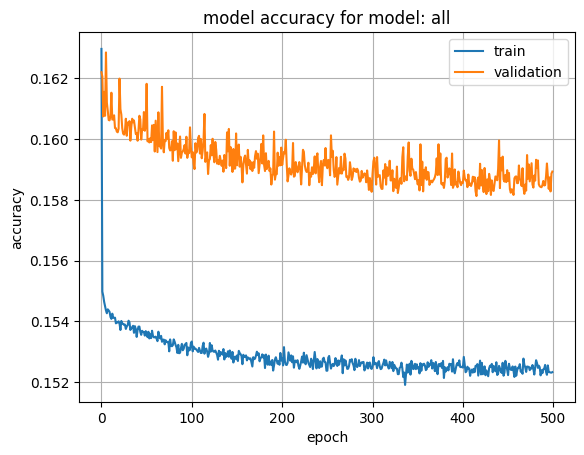

<Sequential name=sequential_3, built=True>

In [18]:
model_data = get_clear_data(ddf)
model = model_data.copy()

train_X, train_y, test_X, test_y = split_dataset(model_data)
model_fit(train_X, train_y, test_X, test_y, epochs=500, batch_size=32, learning_rate=0.001, dev_model="all")


In [56]:
print(test_y)

[39.64456233]
